In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from Functions import *

In [4]:
df = pd.read_csv("D:\\DSEB 63 - NEU\\Năm BA\\Visualization\\Data\\Data\\dseb63_final_project_DP_dataset\\dseb63_bureau_balance.csv")
df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


# Pre check overall Dataframe

In [5]:
df_check = pre_check_tool(df)
df_check.split_data()

In [6]:
# Check null percent
df_check.check_per_null()

,number_missing,percent_missing


In [7]:
# find cols that have null > 90%
print(df_check.find_null_cols(0.9))

Index([], dtype='object')


NO COLUMNS HAVE NULL VALUES > 90% -> SO WE'RE KEEPING THE DATASET AS IT IS FOR NOW

In [8]:
#duplicate check
df.duplicated().sum()

0

In [9]:
# valid value
## Num data
df_check.check_value_num()
print('\n\n\n')

## cat data
df_check.check_value_cat()

SK_ID_BUREAU  has     >0 27299925,  =0 0  ,   <0 0,    nan: 0,   other values: 0
MONTHS_BALANCE  has     >0 0,  =0 610965  ,   <0 26688960,    nan: 0,   other values: 0




col STATUS : ['C', '0', 'X', '1', '2', '3', '5', '4']



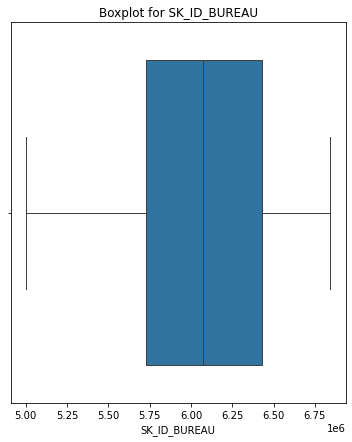

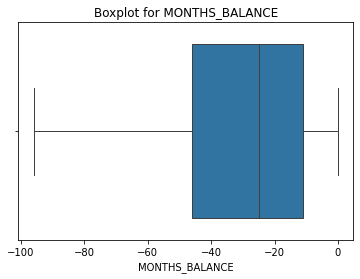

In [10]:
# Outliers 
df_check.show_outliers()

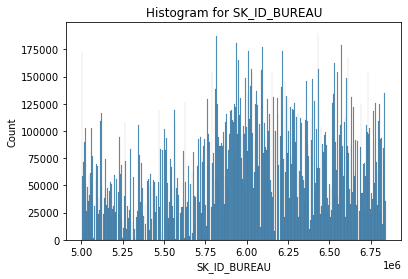

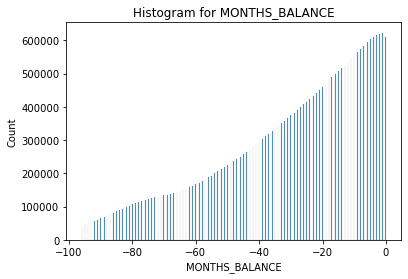

In [12]:
df_check.dist_numchart()

# Data Exploration

# EDA Internal

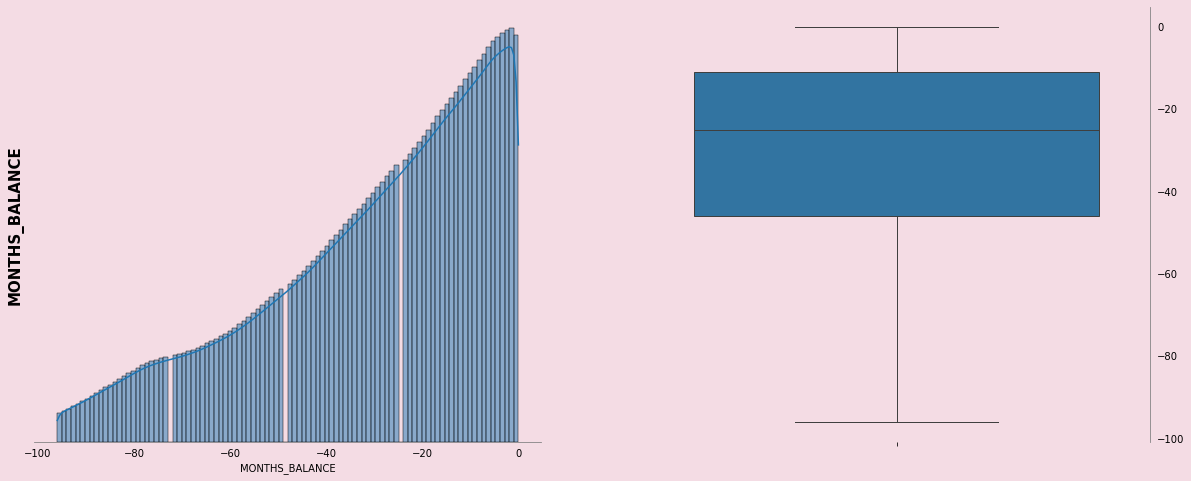

In [13]:
obj1 = Univariate_Analysis(df= df, col= 'MONTHS_BALANCE', num= True)
obj1.visualize()

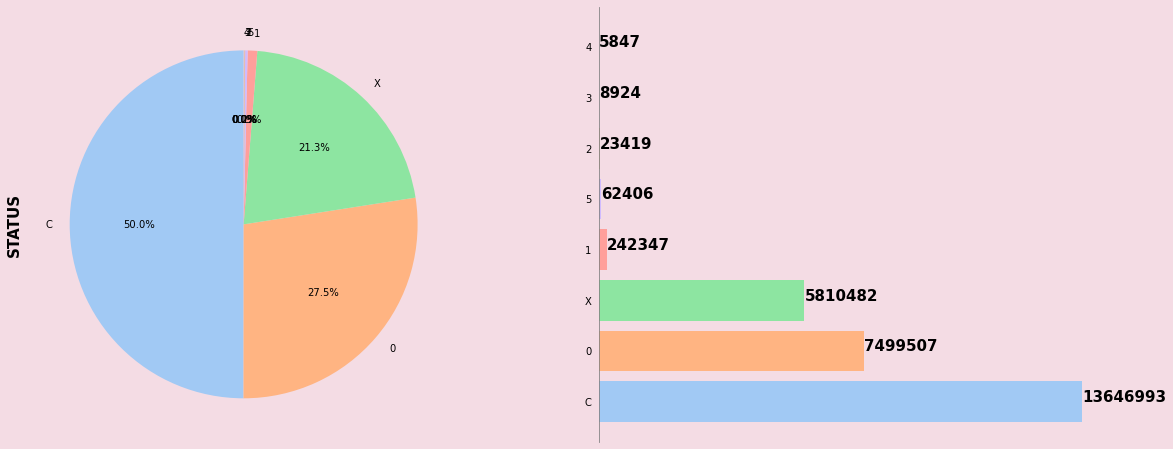

In [14]:
obj2 = Univariate_Analysis(df= df, col= 'STATUS', num= False)
obj2.visualize()

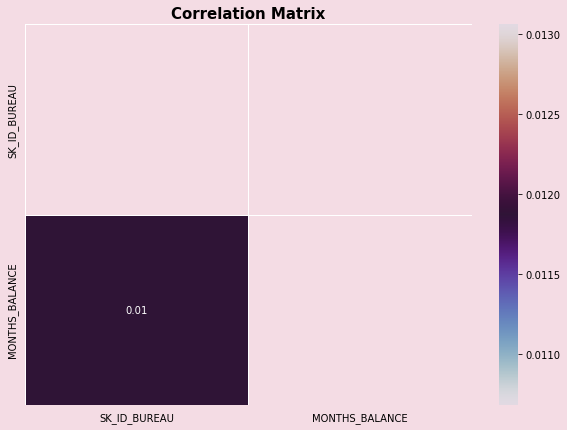

In [15]:
num = df_check.numdf
# Correlation
draw_corr(num)

## EDA External

In [16]:
df2 = pd.read_csv("D:\\DSEB 63 - NEU\\Năm BA\\Visualization\\Data\\Data\\dseb63_final_project_DP_dataset\\dseb63_bureau.csv")
df2.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629


In [17]:
df3 = pd.read_csv("D:\\DSEB 63 - NEU\\Năm BA\\Visualization\\Data\\Data\\dseb63_final_project_DP_dataset\\dseb63_application_train.csv")
df3.head()

,Unnamed: 0,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR
0,0,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,278621
1,1,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,139008
2,2,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,138348
3,3,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,64140
4,4,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,219374


In [18]:
merge_table_prev = pd.merge(df2[['SK_ID_CURR','SK_ID_BUREAU']], df, how= 'left', on=['SK_ID_BUREAU'])
merge_table_prev.head()

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,254629,5714462,NaN,NaN
1,254629,5714463,NaN,NaN
2,254629,5714464,NaN,NaN
3,254629,5714465,NaN,NaN
4,254629,5714466,NaN,NaN


In [19]:
merge_table = pd.merge(df3[["SK_ID_CURR", "TARGET"]], merge_table_prev, how='left', on=['SK_ID_CURR'])
merge_table.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,278621,0,5885877.0,NaN,NaN
1,278621,0,5885878.0,NaN,NaN
2,278621,0,5885879.0,NaN,NaN
3,278621,0,5885880.0,NaN,NaN
4,139008,0,NaN,NaN,NaN


* More insight is in Bureau.ipynb